## import

In [16]:
# !pip install catboost
# !pip install causalml

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from catboost import CatBoostRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import math

# import ylearn
# from ylearn.causal_discovery import CausalDiscovery

In [18]:
# 不输出warn消息
import warnings
warnings.filterwarnings('ignore')

In [19]:
#输出info消息
import logging
log = logging.getLogger()
log.setLevel(logging.INFO)

In [20]:
np.random.seed(2022)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

categorical feature转化

In [21]:
for col in train.columns:
    if train[col].dtype == 'object':
        label_encoder = LabelEncoder().fit(train[col])
        train[col] = label_encoder.transform(train[col])
        test[col] = label_encoder.transform(test[col])

缺失值探查

In [22]:
train_na_dic = {}
test_na_dic = {}
for col in train.columns:
    train_na_dic[col] = train[col].isna().sum()/train.shape[0]
    
for col in test.columns:
    test_na_dic[col] = test[col].isna().sum()/test.shape[0]

In [23]:
train.shape,test.shape

((36188, 42), (5000, 40))

需要填充的缺失值

In [24]:
na_fill_need_col = [x[0] for x in train_na_dic.items() if x[1]>0]

from xgboost.sklearn import XGBClassifier,XGBRegressor
training_col = [x for x in train.columns if x not in ['treatment','outcome']]

for col in na_fill_need_col:
    train_cols = [x for x in training_col if x != col and 'predict' not in x]
    train_na_df = train[~train[col].isna()]
    xgb = XGBRegressor()
    xgb.fit(train_na_df[train_cols],train_na_df[col])
    train[col + '_predict'] = xgb.predict(train[train_cols])
    test[col + '_predict'] = xgb.predict(test[train_cols])

In [25]:
train[train["V_4"].isna()]

,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,V_34,V_35,V_36,V_37,V_38,V_39,treatment,outcome,V_4_predict,V_28_predict
3759,1.366383,3.596721,0.0,-0.896319,NaN,1.0,-42.7,4.963,0,999,...,-2.083103,2.788330,39,1.4,1.0,2.0,0,-30.611807,-1.072978,168.726562
7571,0.420213,4.177450,0.0,-0.845079,NaN,1.0,-40.8,1.262,0,999,...,-4.277656,2.208256,32,-2.9,0.0,3.0,0,16.880377,-1.484512,201.066086
8931,0.469754,4.846877,0.0,2.086365,NaN,1.0,-33.0,0.721,1,999,...,-0.893876,4.268274,38,-3.0,2.0,4.0,2,10.235930,3.539046,341.191406
20161,-0.414293,4.837025,1.0,-0.897769,NaN,1.0,-36.4,4.858,0,999,...,-4.143329,0.670107,56,1.1,0.0,4.0,2,14.361967,-11.078912,29.669884
20781,-1.432754,2.439268,1.0,-1.207616,NaN,1.0,-42.7,4.966,0,999,...,-2.075485,5.735116,46,1.4,1.0,2.0,2,-36.865604,-1.511034,301.035309
28416,-2.216798,-0.532329,0.0,-1.158788,NaN,0.0,-42.7,4.962,0,999,...,-1.838266,3.619340,60,1.4,0.0,1.0,2,5.804737,-5.877168,115.263489
35459,0.908295,0.418790,0.0,-0.375867,NaN,2.0,-46.2,1.244,0,999,...,-5.891295,4.569552,23,-1.8,0.0,1.0,0,-6.731424,3.083890,57.249306
35558,-0.372387,2.768142,0.0,-1.832132,NaN,1.0,-42.0,4.191,0,999,...,-0.693907,0.232484,42,-0.1,0.0,1.0,2,11.786371,-7.797877,229.298599


In [26]:
def fillna(x1,x2):
    if math.isnan(x1):
        return x2
    else:
        return x1
    
for col in na_fill_need_col:
    train[col] = train.apply(lambda x:fillna(x[col],x[col+'_predict']),axis=1) 
    test[col] = test.apply(lambda x:fillna(x[col],x[col+'_predict']),axis=1) 

In [27]:
#数据标准化
# for column in train.columns:
#     if train[column].dtype == 'float':
#         train[column] = (train[column] - train[column].min()) / (train[column].max() - train[column].min())    
        
# for column in test.columns:
#     if test[column].dtype == 'float':
#         test[column] = (test[column] - test[column].min()) / (test[column].max() - test[column].min())
#         train[column] = (train[column] - train[column].min()) / (train[column].max() - train[column].min())

In [28]:
# xlearn 比较重要的特征

# final_train_cols=['V_29', 'V_18','V_1', 'V_17','V_30','V_32', 'V_4', 'V_23', 'V_2', 'V_33', 'V_11', 'V_28', 'V_36']
# final_train_cols=['V_2', 'V_3','V_6', 'V_4','V_15', 'V_17', 'V_28',  'V_34','V_33','V_31']
# final_train_cols=['V_2', 'V_3','V_15', 'V_17', 'V_28',  'V_34','V_33','V_31']

# final_train_cols = ['V_2', 'V_15', 'V_28',  'V_34', 'V_33', 'V_31']
# final_train_cols = ['V_2', 'V_3', 'V_15', 'V_28',  'V_34', 'V_33', 'V_31']
final_train_cols = ['V_2', 'V_15', 'V_28', 'V_8',  'V_34', 'V_33', 'V_31']

In [29]:
from sklearn.preprocessing import RobustScaler
scaler_cols = [x for x in final_train_cols if len(train[x].unique()) >= 10]

t = RobustScaler().fit(train[scaler_cols])
training = t.transform(train[scaler_cols])
testing = t.transform(test[scaler_cols])


train[scaler_cols] = training
test[scaler_cols] = testing

In [30]:
train

,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,V_34,V_35,V_36,V_37,V_38,V_39,treatment,outcome,V_4_predict,V_28_predict
0,1.778505,2.376919,0.0,-1.680176,-1.581142,0.0,-31.4,0.838,0,3,...,-0.029588,6.026618,53,-2.9,0.0,3.0,2,4.745129,-0.677492,216.851562
1,-0.631728,5.337631,0.0,-0.869348,-2.767838,0.0,-42.0,4.120,0,999,...,0.653165,3.011011,50,-0.1,2.0,4.0,0,7.310963,-2.927060,155.730469
2,-0.862595,3.215953,1.0,-1.614799,-2.614270,1.0,-41.8,4.866,0,999,...,-0.654678,4.281093,37,1.4,1.0,2.0,2,-52.156193,-3.517889,407.963501
3,0.230854,2.250193,0.0,-1.631994,-5.705525,1.0,-36.1,4.966,0,999,...,0.649583,3.228095,35,1.4,0.0,3.0,0,-17.011566,-6.039506,253.362244
4,0.194774,4.896442,0.0,-0.143322,2.568728,1.0,-42.7,4.968,0,999,...,-0.081000,4.383740,58,1.4,0.0,2.0,2,-15.229788,2.906383,56.282219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36183,0.826893,4.331358,0.0,-1.551377,-2.904315,0.0,-46.2,1.250,0,999,...,1.221232,5.488357,33,-1.8,1.0,0.0,2,20.512318,-2.799276,177.006546
36184,0.631707,1.383925,0.0,-0.411007,4.483282,1.0,-42.7,4.962,0,999,...,0.098817,1.127706,42,1.4,0.0,4.0,0,-3.178066,5.066493,333.978729
36185,-0.072426,4.918745,0.0,-0.351575,-4.926085,1.0,-36.1,4.963,0,999,...,-0.909237,3.873154,46,1.4,0.0,2.0,0,-43.733190,-4.732676,138.499115
36186,-1.029582,4.633457,0.0,-0.496135,3.944163,1.0,-46.2,1.334,0,999,...,-0.752185,7.455648,39,-1.8,1.0,4.0,2,12.905083,3.446393,160.316284


In [31]:
train.to_csv("train_done.csv",index=False)
test.to_csv("test_done.csv",index=False)

In [32]:
train.head()

,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,V_34,V_35,V_36,V_37,V_38,V_39,treatment,outcome,V_4_predict,V_28_predict
0,1.778505,2.376919,0.0,-1.680176,-1.581142,0.0,-31.4,0.838,0,3,...,-0.029588,6.026618,53,-2.9,0.0,3.0,2,4.745129,-0.677492,216.851562
1,-0.631728,5.337631,0.0,-0.869348,-2.767838,0.0,-42.0,4.120,0,999,...,0.653165,3.011011,50,-0.1,2.0,4.0,0,7.310963,-2.927060,155.730469
2,-0.862595,3.215953,1.0,-1.614799,-2.614270,1.0,-41.8,4.866,0,999,...,-0.654678,4.281093,37,1.4,1.0,2.0,2,-52.156193,-3.517889,407.963501
3,0.230854,2.250193,0.0,-1.631994,-5.705525,1.0,-36.1,4.966,0,999,...,0.649583,3.228095,35,1.4,0.0,3.0,0,-17.011566,-6.039506,253.362244
4,0.194774,4.896442,0.0,-0.143322,2.568728,1.0,-42.7,4.968,0,999,...,-0.081000,4.383740,58,1.4,0.0,2.0,2,-15.229788,2.906383,56.282219


In [33]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train[final_train_cols],train[['treatment','outcome']],test_size = 0.15)

In [34]:
x_train

,V_2,V_15,V_28,V_8,V_34,V_33,V_31
17230,0.0,0,-0.388889,0,0.546533,0.945795,-1.000000
32337,1.0,0,0.356481,0,0.101384,0.162128,0.666667
31967,0.0,0,0.115741,0,-0.787651,0.258349,-0.333333
12003,0.0,2,0.208333,0,-0.228100,1.303288,-1.000000
24874,0.0,0,0.902778,0,-0.701039,0.639252,-1.000000
...,...,...,...,...,...,...,...
2066,0.0,0,0.125000,1,-0.020824,0.117188,1.333333
6384,1.0,0,0.351852,0,-0.276576,0.738618,0.000000
16557,0.0,0,0.490741,0,0.492731,0.971989,-0.333333
1244,1.0,0,-0.226852,0,0.410723,-0.801927,0.666667


In [35]:
y_train

,treatment,outcome
17230,0,-32.812286
32337,2,-19.015150
31967,2,-16.858025
12003,2,-1.301553
24874,0,-25.536934
...,...,...
2066,0,6.904126
6384,2,-26.402786
16557,0,-18.074484
1244,2,-13.187511


##   uber  causalml

## 特征重要性 和 训练


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [37]:
plt.style.use('fivethirtyeight')

In [38]:
# n_features = 25
# n_samples = 10000
# y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [39]:
# x_train,x_test,y_train,y_test

In [40]:
y=y_train["outcome"].values 
w=y_train["treatment"].values 
X=x_train[final_train_cols].values 

y_train["treatment_str"]=y_train["treatment"]
y_train["treatment_str"].replace(0,'control',inplace=True)
y_train["treatment_str"].replace(1,'treatment_a',inplace=True)
y_train["treatment_str"].replace(2,'treatment_b',inplace=True)
w_multi =   y_train["treatment_str"].values
# e_multi = {'treatment_a': e,'treatment_b': e}

In [41]:
# w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])
# e_multi = {'treatment_A': e}

In [42]:
y_train["treatment"].value_counts()

2    17500
0    11804
1     1455
Name: treatment, dtype: int64

In [43]:
sum(y_train["treatment"].value_counts())

30759

In [44]:
feature_names=final_train_cols

In [45]:
feature_names

['V_2', 'V_15', 'V_28', 'V_8', 'V_34', 'V_33', 'V_31']

In [46]:
# final_train_cols

In [47]:
## S Learner

### S Learner Feature Importance 

In [48]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):    11.9904
INFO:causalml:    RMSE (Treatment):    11.4680
INFO:causalml:   sMAPE   (Control):     0.6236
INFO:causalml:   sMAPE (Treatment):     0.5730
INFO:causalml:    Gini   (Control):     0.6992
INFO:causalml:    Gini (Treatment):     0.7501
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):    12.3972
INFO:causalml:    RMSE (Treatment):    12.3444
INFO:causalml:   sMAPE   (Control):     0.6407
INFO:causalml:   sMAPE (Treatment):     0.9850
INFO:causalml:    Gini   (Control):     0.6692
INFO:causalml:    Gini (Treatment):     0.6353


array([ 1.35070333, 12.87230311])

In [49]:
slearner.estimate_ate(X, w_multi, y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):    11.9904
INFO:causalml:    RMSE (Treatment):    11.4680
INFO:causalml:   sMAPE   (Control):     0.6236
INFO:causalml:   sMAPE (Treatment):     0.5730
INFO:causalml:    Gini   (Control):     0.6992
INFO:causalml:    Gini (Treatment):     0.7501
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):    12.3972
INFO:causalml:    RMSE (Treatment):    12.3444
INFO:causalml:   sMAPE   (Control):     0.6407
INFO:causalml:   sMAPE (Treatment):     0.9850
INFO:causalml:    Gini   (Control):     0.6692
INFO:causalml:    Gini (Treatment):     0.6353


array([ 1.35070333, 12.87230311])

In [50]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):    11.9904
INFO:causalml:    RMSE (Treatment):    11.4680
INFO:causalml:   sMAPE   (Control):     0.6236
INFO:causalml:   sMAPE (Treatment):     0.5730
INFO:causalml:    Gini   (Control):     0.6992
INFO:causalml:    Gini (Treatment):     0.7501
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):    12.3972
INFO:causalml:    RMSE (Treatment):    12.3444
INFO:causalml:   sMAPE   (Control):     0.6407
INFO:causalml:   sMAPE (Treatment):     0.9850
INFO:causalml:    Gini   (Control):     0.6692
INFO:causalml:    Gini (Treatment):     0.6353


In [51]:
slearner._classes

{'treatment_a': 0, 'treatment_b': 1}

In [52]:
slearner_tau

array([[-0.60383046, 16.23280793],
       [ 2.79968088, 13.10150196],
       [ 3.05307783, 13.61066398],
       ...,
       [ 2.09434975, 12.65874396],
       [ 0.40428387, 16.401569  ],
       [ 0.94260431, 14.98851453]])

In [53]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=final_train_cols)

{'treatment_a': V_28    0.544894
 V_31    0.166824
 V_2     0.131738
 V_15    0.062118
 V_34    0.048910
 V_33    0.031158
 V_8     0.014359
 dtype: float64,
 'treatment_b': V_28    0.700376
 V_15    0.108119
 V_8     0.071440
 V_31    0.062045
 V_2     0.030538
 V_33    0.013970
 V_34    0.013511
 dtype: float64}

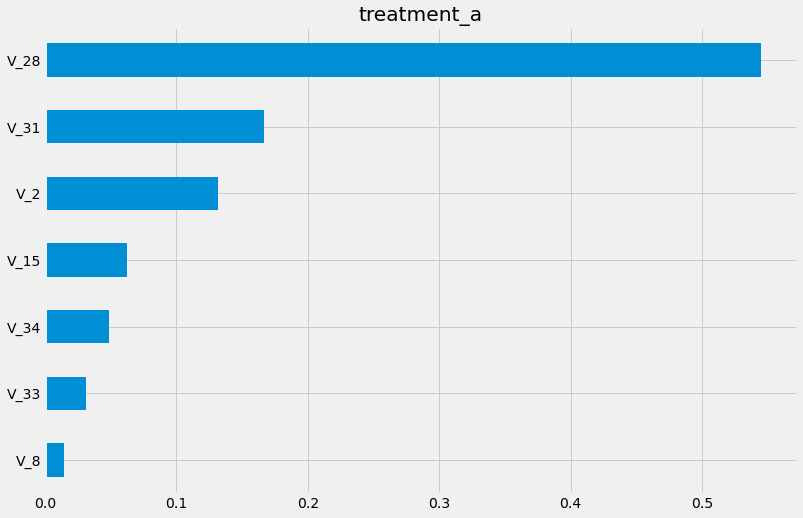

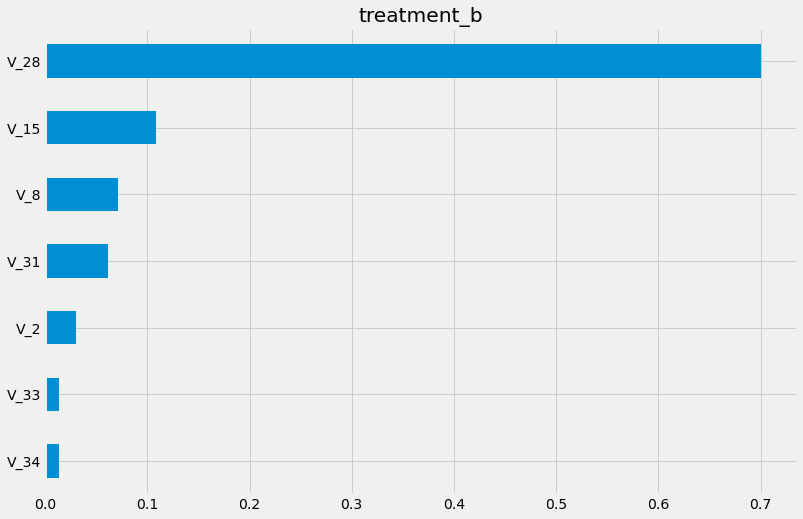

In [54]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

In [55]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_a': V_28    1.664926
 V_31    0.498190
 V_2     0.320997
 V_34    0.126495
 V_15    0.118996
 V_33    0.069544
 V_8     0.025548
 dtype: float64,
 'treatment_b': V_28    1.392719
 V_15    0.264256
 V_31    0.158959
 V_8     0.116103
 V_2     0.087227
 V_33    0.026558
 V_34    0.024132
 dtype: float64}

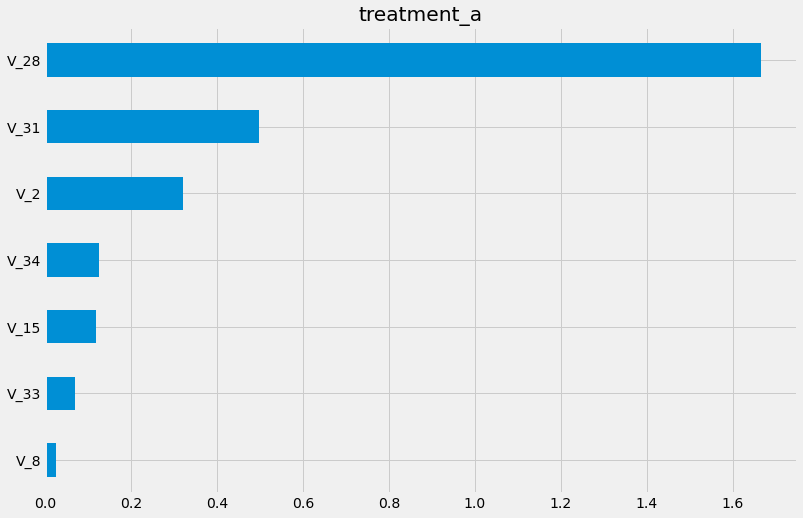

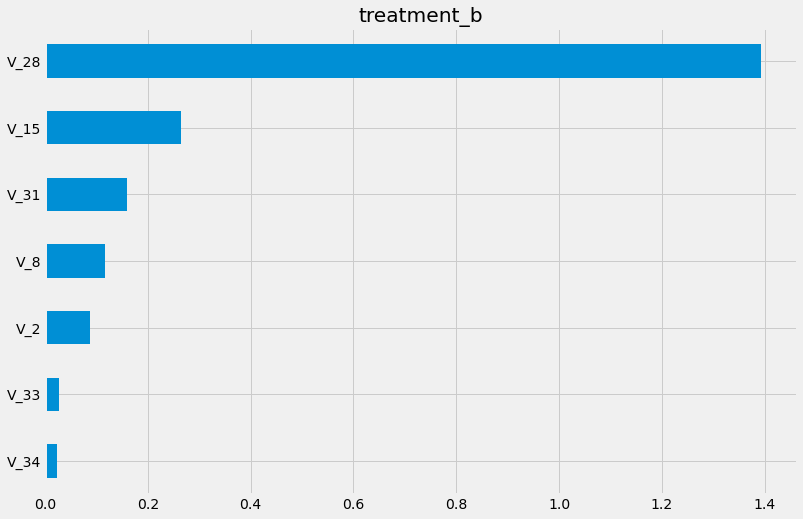

In [56]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

In [452]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner


{'treatment_a': array([[ 0.044,  0.085,  0.113, ...,  0.343, -0.566,  0.907],
        [-0.033,  0.12 ,  0.034, ...,  0.115,  0.099, -0.819],
        [-0.296,  0.191,  0.161, ...,  0.106,  0.22 ,  0.485],
        ...,
        [ 0.034,  0.115,  0.027, ..., -0.027, -0.135, -0.696],
        [-0.054,  0.095, -1.312, ..., -0.022,  0.152,  0.467],
        [ 0.182,  0.266,  0.075, ...,  0.295,  0.137, -0.066]]),
 'treatment_b': array([[ 0.095, -0.142,  0.491, ..., -0.02 , -0.129, -0.514],
        [ 0.106, -0.184,  0.473, ...,  0.115, -0.083,  1.289],
        [ 0.099,  0.111,  0.428, ..., -0.095,  0.048, -0.557],
        ...,
        [ 0.057, -0.067,  0.425, ...,  0.292, -0.079,  0.163],
        [ 0.202,  0.121, -2.682, ..., -0.049,  0.026, -0.315],
        [-0.276,  0.132,  0.773, ...,  0.075,  0.153,  0.571]])}

In [453]:
np.mean(np.abs(shap_slearner['treatment_a']),axis=0)

array([0.276, 0.216, 0.172, 1.141, 0.172, 0.189, 0.533])

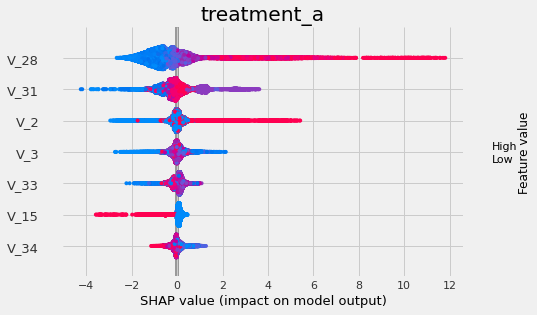

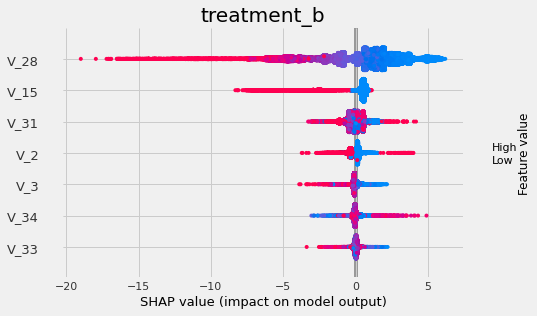

In [454]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

### T Learner Feature Importance 

In [581]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([ 1.586, 12.886]), array([ 1.113, 12.603]), array([ 2.059, 13.169]))

In [582]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

In [583]:
tlearner.predict(X=X,return_components=True)

(array([[-5.24 ,  6.573],
        [-4.3  , 15.064],
        [ 0.833, 14.008],
        ...,
        [-7.328,  9.842],
        [ 7.246,  7.548],
        [-3.473, 14.742]]),
 {'treatment_a': array([-11.214, -22.707, -19.002, ..., -31.766,   3.368, -18.58 ]),
  'treatment_b': array([-11.214, -22.707, -19.002, ..., -31.766,   3.368, -18.58 ])},
 {'treatment_a': array([-16.453, -27.007, -18.168, ..., -39.094,  10.613, -22.053]),
  'treatment_b': array([ -4.641,  -7.643,  -4.994, ..., -21.924,  10.916,  -3.838])})

In [459]:
tlearner_tau

array([[-5.24 ,  6.573],
       [-4.3  , 15.064],
       [ 0.833, 14.008],
       ...,
       [-7.328,  9.842],
       [ 7.246,  7.548],
       [-3.473, 14.742]])

In [460]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_a': V_28    0.375042
 V_31    0.208519
 V_3     0.121491
 V_34    0.097509
 V_33    0.085050
 V_2     0.058549
 V_15    0.053838
 dtype: float64,
 'treatment_b': V_28    0.635537
 V_31    0.078030
 V_3     0.072112
 V_15    0.070613
 V_34    0.056813
 V_33    0.050175
 V_2     0.036720
 dtype: float64}

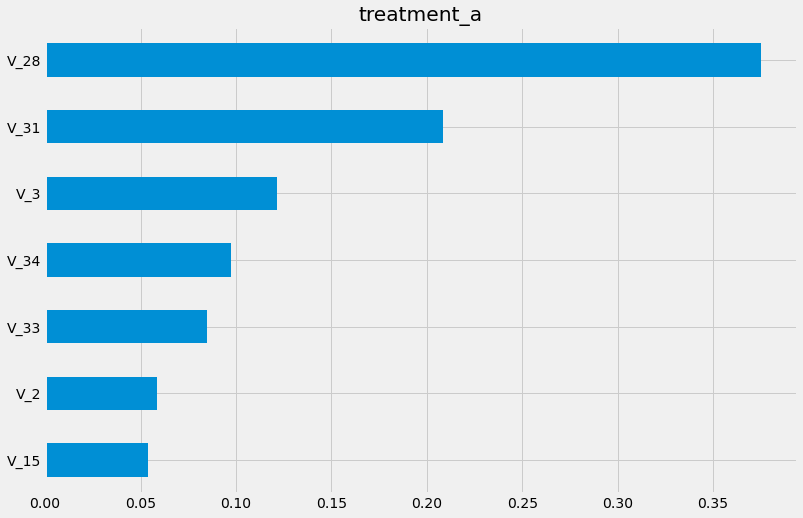

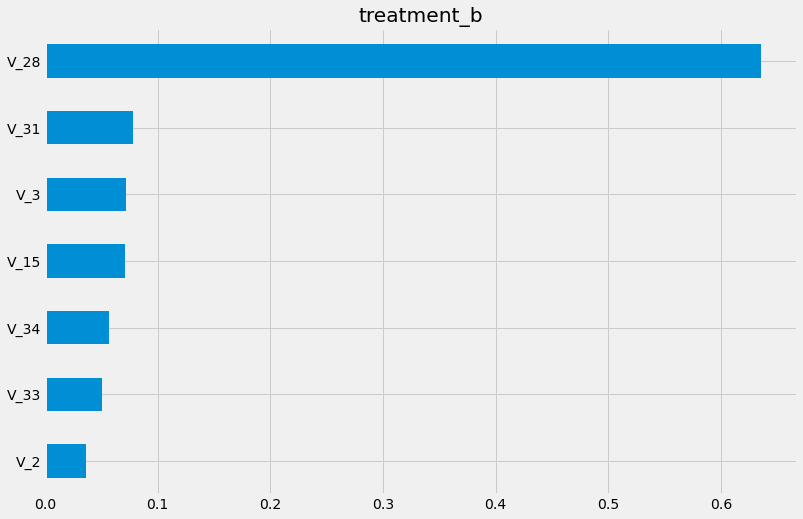

In [461]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

In [462]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_a': V_28    0.892625
 V_31    0.389301
 V_3     0.203594
 V_34    0.171307
 V_33    0.162526
 V_15    0.130765
 V_2     0.128153
 dtype: float64,
 'treatment_b': V_28    1.098968
 V_15    0.145261
 V_31    0.129132
 V_3     0.092947
 V_34    0.080587
 V_33    0.076981
 V_2     0.069860
 dtype: float64}

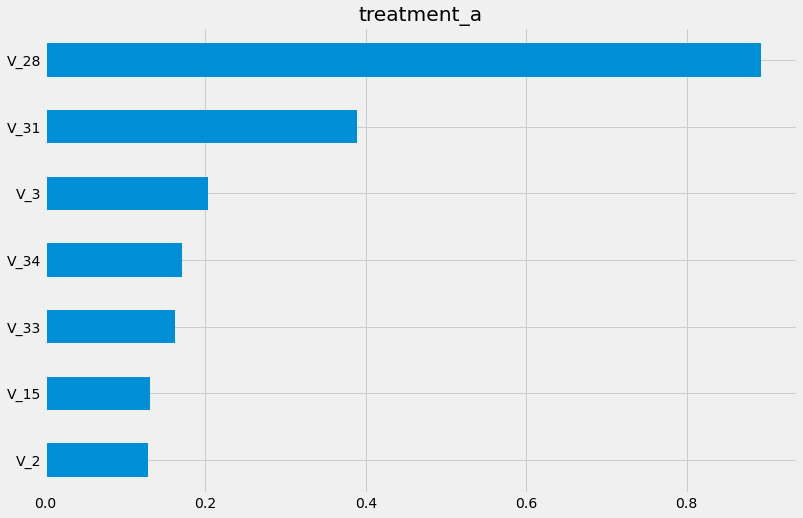

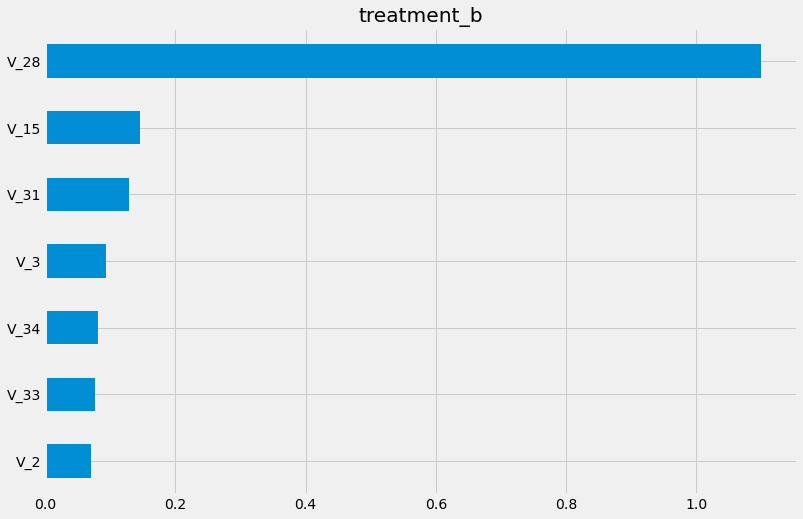

In [463]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

In [464]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'treatment_a': array([[ 0.374, -1.836,  0.193, ...,  0.051, -0.854, -0.452],
        [ 0.081, -1.69 , -0.345, ..., -1.096,  1.186, -2.193],
        [ 0.026,  2.28 ,  0.276, ..., -0.587, -0.383,  2.046],
        ...,
        [-0.471, -0.438, -0.108, ..., -2.347, -0.839, -2.555],
        [ 0.634,  1.893, -1.702, ..., -0.029,  1.103,  0.094],
        [-0.113,  1.878,  0.311, ..., -0.182, -2.614,  0.825]]),
 'treatment_b': array([[-0.223, -0.457,  0.417, ...,  0.049, -1.916, -1.034],
        [-0.214, -1.033,  0.361, ...,  0.249,  0.11 ,  1.786],
        [-0.307,  0.105,  0.385, ..., -0.182,  0.203, -0.165],
        ...,
        [-0.257, -0.222,  0.345, ..., -0.355, -0.224,  0.66 ],
        [-0.031,  0.197, -2.634, ...,  0.4  , -0.063, -1.048],
        [ 0.092,  0.182,  0.424, ..., -0.236,  0.319,  0.214]])}

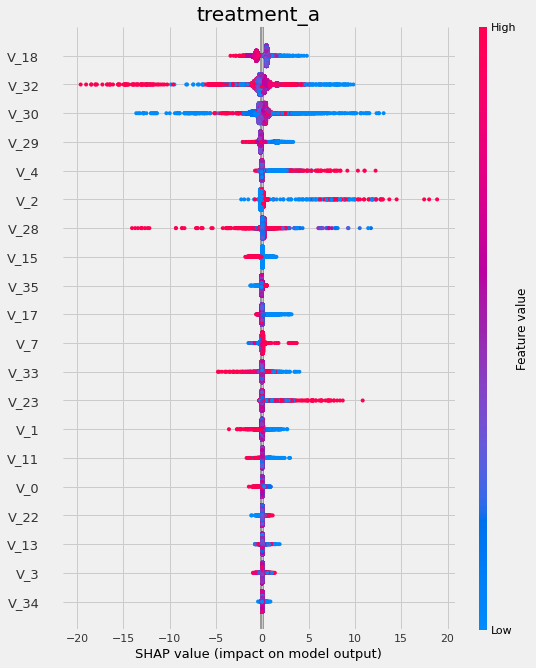

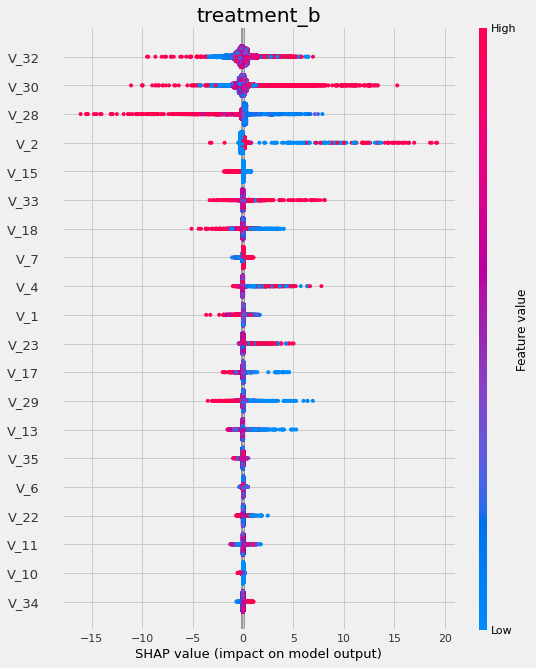

In [ ]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

### X Learner Feature Importance

In [522]:
# xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner = BaseXRegressor(XGBRegressor(), control_name='control')
xlearner.estimate_ate(X, w_multi, y)

(array([ 1.624, 12.918]), array([ 1.155, 12.637]), array([ 2.093, 13.199]))

In [523]:
X.shape

(30759, 7)

In [524]:
xlearner_tau = xlearner.fit_predict(X, w_multi, y)

In [525]:
xlearner_tau

array([[-0.716,  9.814],
       [ 1.983, 14.019],
       [ 3.401, 13.71 ],
       ...,
       [-3.363, 18.557],
       [12.956,  8.841],
       [-1.332, 13.643]])

In [529]:
xlearner.t_groups

array(['treatment_a', 'treatment_b'], dtype=object)

In [531]:
# xlearner.predict??

In [532]:
xlearner.predict(X,return_components=True)

(array([[-0.954,  9.807],
        [ 0.685, 14.117],
        [ 3.564, 13.904],
        ...,
        [-4.195, 17.604],
        [12.104,  8.806],
        [-1.113, 13.686]]),
 {'treatment_a': array([-2.904, -2.093,  5.324, ..., -8.83 ,  3.788,  0.583]),
  'treatment_b': array([ 9.818, 14.568, 14.61 , ..., 18.701,  8.701, 13.269])},
 {'treatment_a': array([-0.628,  2.292,  3.323, ..., -3.101, 13.323, -1.41 ]),
  'treatment_b': array([ 9.774, 13.768, 12.742, ..., 12.784,  8.968, 14.634])})

In [533]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_a': V_28    0.405184
 V_3     0.166043
 V_33    0.149575
 V_34    0.136372
 V_31    0.106917
 V_15    0.019671
 V_2     0.016238
 dtype: float64,
 'treatment_b': V_28    0.708097
 V_15    0.073745
 V_3     0.066497
 V_34    0.056644
 V_33    0.051296
 V_31    0.036089
 V_2     0.007633
 dtype: float64}

In [534]:
xlearner_tau

array([[-0.716,  9.814],
       [ 1.983, 14.019],
       [ 3.401, 13.71 ],
       ...,
       [-3.363, 18.557],
       [12.956,  8.841],
       [-1.332, 13.643]])

In [535]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_a': V_28    0.405184
 V_3     0.166043
 V_33    0.149575
 V_34    0.136372
 V_31    0.106917
 V_15    0.019671
 V_2     0.016238
 dtype: float64,
 'treatment_b': V_28    0.708097
 V_15    0.073745
 V_3     0.066497
 V_34    0.056644
 V_33    0.051296
 V_31    0.036089
 V_2     0.007633
 dtype: float64}

In [536]:

xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_a': V_28    0.897635
 V_3     0.325324
 V_33    0.287759
 V_34    0.263665
 V_31    0.243764
 V_15    0.041941
 V_2     0.024496
 dtype: float64,
 'treatment_b': V_28    1.383572
 V_15    0.136239
 V_3     0.131952
 V_34    0.107842
 V_33    0.101971
 V_31    0.069886
 V_2     0.010692
 dtype: float64}

In [537]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'treatment_a': array([[ 0.219, -1.627,  0.195, ..., -0.008,  1.021, -0.222],
        [ 0.17 , -1.743, -0.003, ..., -0.51 ,  1.153, -1.069],
        [ 0.126,  2.816,  0.034, ..., -0.003, -1.083,  1.8  ],
        ...,
        [-0.019,  0.935, -0.055, ..., -1.889, -0.557, -2.363],
        [ 0.233,  2.957, -0.388, ...,  0.049,  2.102,  0.632],
        [-0.264,  2.646,  0.142, ..., -0.265, -2.77 ,  0.88 ]]),
 'treatment_b': array([[-0.012, -0.347,  0.391, ..., -0.389, -1.605, -0.353],
        [-0.098, -1.139,  0.322, ...,  0.186,  0.006,  1.559],
        [-0.011,  0.127,  0.373, ..., -0.269,  0.232, -0.151],
        ...,
        [-0.106, -0.098,  0.345, ..., -0.206,  1.84 ,  0.803],
        [-0.001,  0.166, -1.851, ...,  0.392, -0.127, -0.423],
        [ 0.02 ,  0.107,  0.359, ..., -0.345,  0.137, -0.091]])}

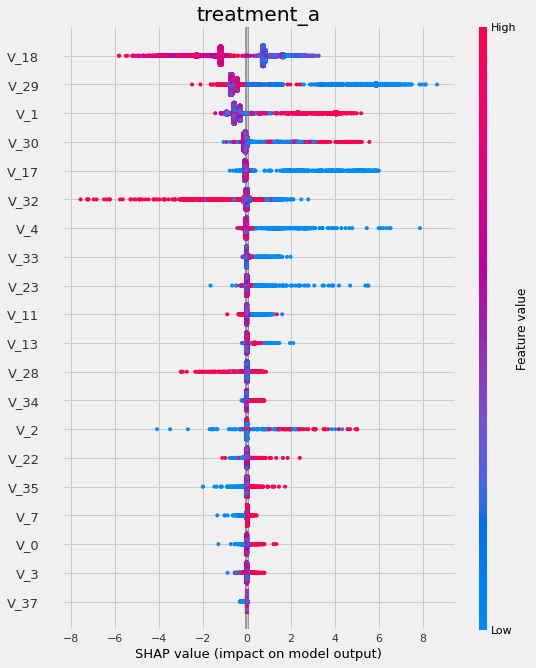

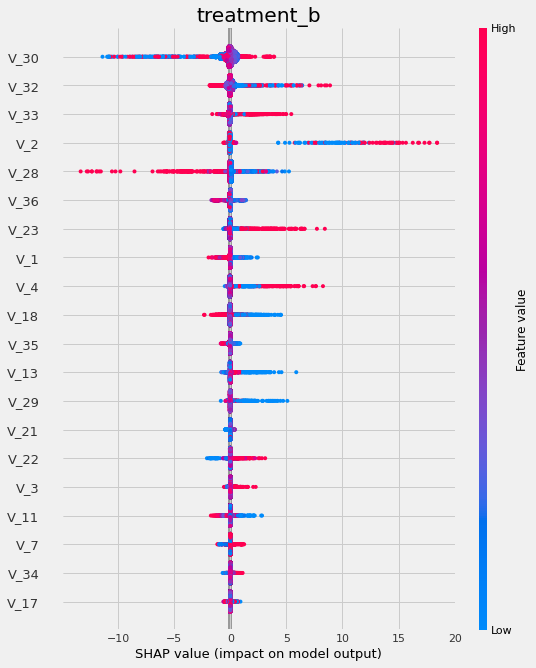

In [ ]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_names)

### R Learner Feature Importance

In [ ]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner_tau = rlearner.fit_predict(X, w_multi, y)

In [ ]:
rlearner_tau

array([[-0.59033227,  1.94705177],
       [ 0.55632175,  2.3526243 ],
       [-0.22449058, -0.50553489],
       ...,
       [-2.09342226,  2.02282799],
       [-8.39344134, -8.23941137],
       [-0.89402882, -1.98746266]])

In [ ]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_a': V_18    0.436717
 V_17    0.173933
 V_22    0.070347
 V_13    0.039238
 V_26    0.039231
 V_3     0.035227
 V_30    0.025648
 V_23    0.022865
 V_1     0.019208
 V_33    0.017783
 V_4     0.014663
 V_34    0.014645
 V_32    0.011145
 V_36    0.010747
 V_29    0.009820
 V_11    0.008543
 V_39    0.007638
 V_0     0.006474
 V_7     0.005128
 V_19    0.004541
 V_28    0.004431
 V_35    0.003961
 V_38    0.003620
 V_24    0.003461
 V_21    0.002185
 V_14    0.001890
 V_2     0.001836
 V_6     0.001772
 V_12    0.001310
 V_31    0.000605
 V_5     0.000505
 V_25    0.000499
 V_8     0.000179
 V_37    0.000136
 V_15    0.000045
 V_10    0.000025
 V_16    0.000000
 V_9     0.000000
 V_27    0.000000
 V_20    0.000000
 dtype: float64, 'treatment_b': V_22    0.068049
 V_35    0.067337
 V_33    0.065912
 V_30    0.061765
 V_28    0.051855
 V_13    0.049649
 V_18    0.047812
 V_36    0.047724
 V_29    0.042575
 V_7     0.037680
 V_4     0.036385
 V_32    0.036236
 V_3     0.035868


In [ ]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_a': V_18    1.128078e+00
 V_17    1.795697e-01
 V_29    9.581019e-02
 V_22    8.629243e-02
 V_13    6.862166e-02
 V_26    6.235980e-02
 V_3     5.551763e-02
 V_30    3.184461e-02
 V_23    3.093062e-02
 V_4     2.239342e-02
 V_1     1.978894e-02
 V_33    1.864658e-02
 V_39    9.753915e-03
 V_36    9.652732e-03
 V_34    7.668076e-03
 V_6     4.484977e-03
 V_21    4.400093e-03
 V_28    4.064095e-03
 V_0     3.616883e-03
 V_32    2.836543e-03
 V_7     2.282774e-03
 V_38    3.975555e-04
 V_2     3.747728e-04
 V_25    2.337834e-04
 V_8     8.349122e-05
 V_5     4.077101e-05
 V_9     0.000000e+00
 V_16    0.000000e+00
 V_20    0.000000e+00
 V_27    0.000000e+00
 V_15    0.000000e+00
 V_37   -6.041320e-07
 V_10   -4.369449e-05
 V_31   -1.902325e-04
 V_24   -2.921482e-04
 V_11   -5.907082e-04
 V_12   -6.476793e-04
 V_35   -1.076467e-03
 V_19   -1.139574e-03
 V_14   -7.399320e-03
 dtype: float64, 'treatment_b': V_35    0.097865
 V_28    0.088933
 V_33    0.067804
 V_36    0.060976
 V

In [ ]:
shap_rlearner = rlearner.get_shap_values(X=X, tau=rlearner_tau)
shap_rlearner

{'treatment_a': array([[-1.79551748e-01,  5.77869223e-01, -1.60251434e-02, ...,
          5.29741276e-03, -2.48736153e-02,  3.18044473e-01],
        [-3.99254879e-01,  1.35669947e+00, -1.39010045e-02, ...,
         -3.24485283e-03, -2.63614289e-02, -3.54722028e-01],
        [ 3.19904863e-02, -1.20960534e+00, -1.37403209e-02, ...,
          4.90973078e-04,  4.04172212e-02, -5.41446009e-01],
        ...,
        [-5.28985585e-01,  4.44577302e-01, -1.30669305e-02, ...,
          5.29741276e-03, -2.72867959e-02, -1.79187662e-01],
        [ 2.02240813e-01, -1.24745972e+00, -1.06920782e-02, ...,
          4.90973078e-04,  4.54770252e-02, -2.68200060e-01],
        [ 1.54664108e-01,  1.89292556e-01,  1.06142714e-02, ...,
          1.04467087e-02, -2.89774198e-02,  9.71939129e-02]]),
 'treatment_b': array([[ 1.27439155e-01,  4.18777353e-02, -2.97339141e-02, ...,
         -6.19970707e-04,  4.41493302e-02,  1.79191886e-02],
        [ 1.20085841e-01, -1.13462867e-01, -3.53369627e-02, ...,
        

In [ ]:

rlearner

BaseRRegressor
	outcome_learner=LGBMRegressor()
	effect_learner=LGBMRegressor()
	propensity_learner=LogisticRegressionCV(Cs=array([1.00230524, 2.15608891, 4.63802765, 9.97700064]),
                     cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                     l1_ratios=array([0.001     , 0.33366667, 0.66633333, 0.999     ]),
                     penalty='elasticnet', random_state=42, solver='saga')

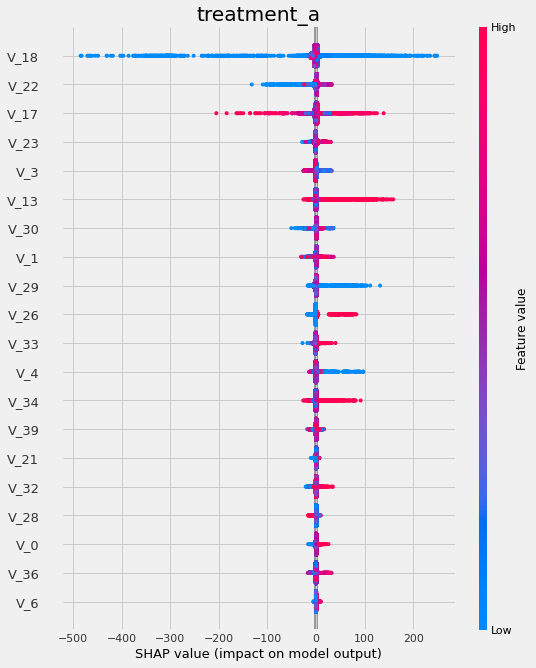

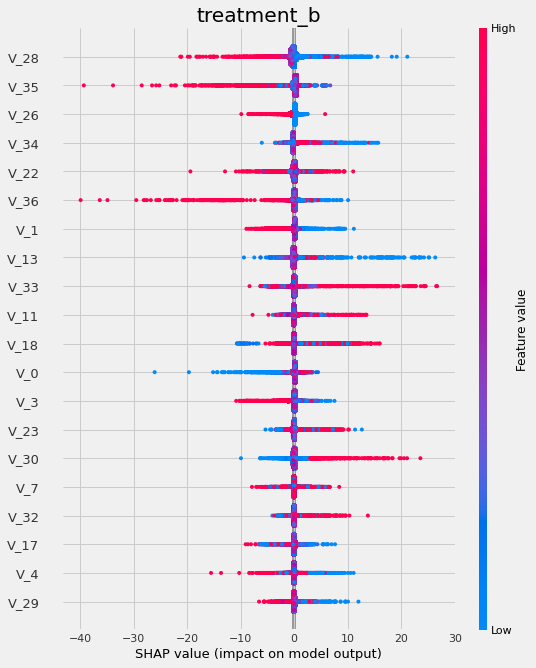

In [ ]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, tau=rlearner_tau, features=feature_names)

In [ ]:
4336

### dr_learner

In [181]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import BaseXRegressor, BaseDRRegressor
from causalml.inference.iv import BaseDRIVRegressor
from causalml.dataset import synthetic_data
from causalml.metrics import *

In [182]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

In [ ]:
X, w_multi, y)

In [188]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression(),control_name='control')
cate_x = learner_x.fit_predict(X=X, treatment=w_multi, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.0747
INFO:causalml:    RMSE (Treatment):     0.0454
INFO:causalml:   sMAPE   (Control):     0.0102
INFO:causalml:   sMAPE (Treatment):     0.0040
INFO:causalml:    Gini   (Control):     1.0000
INFO:causalml:    Gini (Treatment):     1.0000
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.0747
INFO:causalml:    RMSE (Treatment):     0.0795
INFO:causalml:   sMAPE   (Control):     0.0102
INFO:causalml:   sMAPE (Treatment):     0.0171
INFO:causalml:    Gini   (Control):     1.0000
INFO:causalml:    Gini (Treatment):     1.0000


In [192]:
cate_x

array([[ 0.41601486,  0.02093741],
       [-0.12372998, -0.06416653],
       [-0.42923181, -0.20897953],
       ...,
       [-1.0111081 , -0.03284108],
       [ 0.05089757,  0.09128658],
       [-0.51568293, -0.20933515]])

In [189]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression(),control_name='control')
cate_dr = learner_dr.fit_predict(X=X, treatment=w_multi, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Generate outcome regressions
INFO:causalml:Fit pseudo outcomes from the DR formula
INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Generate outcome regressions
INFO:causalml:Fit pseudo outcomes from the DR formula
INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Generate outcome regressions
INFO:causalml:Fit pseudo outcomes from the DR formula
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     1.6486
INFO:causalml:    RMSE (Treatment):     2.2954
INFO:causalml:   sMAPE   (Control):     0.0145
INFO:causalml:   sMAPE (Treatment):     0.0234
INFO:causalml:    Gini   (Control):     0.9959
INFO:causalml:    Gini (Trea

In [193]:
cate_dr

array([[ 0.33020233,  0.03994293],
       [ 0.32796208,  0.13310177],
       [-0.97879351, -0.58952072],
       ...,
       [-0.28969531,  0.03508306],
       [ 1.14172255,  0.69252683],
       [-0.70279846,  0.51595651]])

In [191]:
learner_dr.predict(X)

array([[ 0.33020233,  0.03994293],
       [ 0.32796208,  0.13310177],
       [-0.97879351, -0.58952072],
       ...,
       [-0.28969531,  0.03508306],
       [ 1.14172255,  0.69252683],
       [-0.70279846,  0.51595651]])

##  lingam 不同特征的影响

In [400]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.21.5', '1.4.2', '0.20.1', '1.6.0']


In [401]:
make_dot??

In [1082]:
model = lingam.DirectLiNGAM()
model.fit(train)
make_dot(model.adjacency_matrix_)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
matrix = model.adjacency_matrix_

In [ ]:
import numpy as np

## 自动调参的尝试

###  暂时不用调参

In [ ]:
# 暂时不用

import numpy as np
import pandas as pd
from random import shuffle
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBClassifier,XGBRegressor
import pickle
import time
import xgboost.sklearn as xgb
from hyperopt import fmin, tpe, hp,space_eval,rand,Trials,partial,STATUS_OK

from sklearn.model_selection import cross_val_score


# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'learning_rate': hp.choice('learning_rate',    np.arange(0.005, 0.41, 0.05))
#     }


space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'learning_rate': hp.choice('learning_rate',    np.arange(0.05, 0.41, 0.05)),
       'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
       'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
       'subsample':        hp.uniform('subsample', 0.8, 1),
       'n_estimators':     100,
       'gamma': hp.uniform ('gamma', 1,9)
    }




# Regression: 
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), 
                           learning_rate = space['learning_rate'])
            
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    model.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(x_test)
    mse= mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK, 'model': model}
    
# Classifier:
# def hyperparameter_tuning(space):
#     model = xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
#                          reg_alpha = int(space['reg_alpha'],min_child_weight=space['min_child_weight'],
#                          colsample_bytree=space['colsample_bytree']))
#     evaluation = [( x_train, y_train), ( x_test, y_test)]
    
#     model.fit(x_train, y_train,
#             eval_set=evaluation, eval_metric="rmse",
#             early_stopping_rounds=10,verbose=False)

#     pred = model.predict(x_test)
#     accuracy = accuracy_score(y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     #change the metric if you like
#     return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)
best_trial=trials.best_trial
xgb = best_trial["result"]["model"]

### hyperopt 调参

调参参考示例 https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

In [58]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [29]:
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK, 'model':reg}

In [30]:
# x_train['treatment'] = y_train["treatment"]
# outcome_train = y_train['outcome']
# # train = train[final_cols + ['treatment']]

In [31]:
x_train['treatment'] = y_train["treatment"]
x_test['treatment'] = y_test["treatment"]

In [32]:
x_train

,V_2,V_15,V_28,V_8,V_34,V_33,V_31,treatment
17230,0.0,0,-0.388889,0,0.546533,0.945795,-1.000000,0
32337,1.0,0,0.356481,0,0.101384,0.162128,0.666667,2
31967,0.0,0,0.115741,0,-0.787651,0.258349,-0.333333,2
12003,0.0,2,0.208333,0,-0.228100,1.303288,-1.000000,2
24874,0.0,0,0.902778,0,-0.701039,0.639252,-1.000000,0
...,...,...,...,...,...,...,...,...
2066,0.0,0,0.125000,1,-0.020824,0.117188,1.333333,0
6384,1.0,0,0.351852,0,-0.276576,0.738618,0.000000,2
16557,0.0,0,0.490741,0,0.492731,0.971989,-0.333333,0
1244,1.0,0,-0.226852,0,0.410723,-0.801927,0.666667,2


In [33]:
#输出info消息
import logging
log = logging.getLogger()
log.setLevel(logging.WARN)

In [34]:
# obj = HPOpt(x_train, x_test, y_train, y_test)
obj = HPOpt(x_train, x_test, y_train[["outcome"]], y_test[["outcome"]])
                                                          
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
# lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
# ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)

100%|██████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/trial, best loss: 13.339236804230822]


In [739]:
_, trials = xgb_opt
xgb_model=trials.best_trial["result"]["model"]

In [845]:
xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7000000000000002,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 5,
 'max_leaves': 0,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.9109639107460298,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [195]:
#['V_2', 'V_3', 'V_4', 'V_6', 'V_11', 'V_15', 'V_17', 'V_19', 'V_28', 'V_30', 'V_34', 'V_39#']
# gb_opt1,lgb_opt1,ctb_opt1 = (xgb_opt,lgb_opt,ctb_opt)

In [201]:
#['V_2', 'V_3','V_15', 'V_17', 'V_28',  'V_34','V_33','V_31']
# gb_opt2,lgb_opt2,ctb_opt2 = (xgb_opt,lgb_opt,ctb_opt)

In [315]:
#['V_2','V_15', 'V_28',  'V_34','V_33','V_31']
gb_opt3,lgb_opt3,ctb_opt3 = (xgb_opt,lgb_opt,ctb_opt)


In [472]:
x_test.shape,x_test.shape

((5429, 8), (5429, 8))

In [35]:
_, trials = xgb_opt
xgb_model=trials.best_trial["result"]["model"]

_, trials = lgb_opt
lgb_model=trials.best_trial["result"]["model"]

_, trials = ctb_opt
ctb_model=trials.best_trial["result"]["model"]

In [480]:
## loss

# catboost : 'loss': 0.0008436747
# LGBMRegressor: 'loss': 0.001830
# XGBRegressor: 'loss': 0.00168

In [37]:
np.sqrt(mean_squared_error(xgb_model.predict(x_test), y_test[["outcome"]]))

13.339236804230822

## 预测

In [38]:
train = pd.read_csv("train_done.csv")
test = pd.read_csv("test_done.csv")

# train = pd.read_csv("train_done_norm.csv")
# test = pd.read_csv("test_done_norm.csv")

In [39]:
train.head(1)

,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,V_34,V_35,V_36,V_37,V_38,V_39,treatment,outcome,V_4_predict,V_28_predict
0,1.778505,2.376919,0.0,-1.680176,-1.581142,0.0,-31.4,0.838,0,3,...,-0.029588,6.026618,53,-2.9,0.0,3.0,2,4.745129,-0.677492,216.85156


In [40]:
train_treat_ori=train["treatment"]
outcome_train=train["outcome"]

In [41]:
x_train.columns

Index(['V_2', 'V_15', 'V_28', 'V_8', 'V_34', 'V_33', 'V_31', 'treatment'], dtype='object')

In [42]:
list(final_train_cols)==list(x_train.columns)

False

In [43]:
def predict(train,modelList):
    train=train[final_train_cols]
    train['treatment'] = 1
    result=[]
    for model in modelList:
        result.append(model.predict(train))
    train_ensemble_treat1 = sum(result)/len(result)
    
    train['treatment'] = 2
    result=[]
    for model in modelList:
        result.append(model.predict(train))
    train_ensemble_treat2 = sum(result)/len(result)
    
    train['treatment'] = 0
    result=[]
    for model in modelList:
        result.append(model.predict(train))
    train_ensemble_treat0 = sum(result)/len(result)
    
    train['t1_pred'] = train_ensemble_treat1
    train['t2_pred'] = train_ensemble_treat2
    train['t0_pred'] = train_ensemble_treat0
    
    return train

In [44]:
modelList=[]
modelList.append(xgb_model)
# modelList.append(lgb_model)
# modelList.append(ctb_model)

In [45]:
final_train_cols

['V_2', 'V_15', 'V_28', 'V_8', 'V_34', 'V_33', 'V_31']

In [46]:
train=predict(train,modelList)
train['t_ori'] = train_treat_ori
train['outcome'] = outcome_train

In [47]:
test=predict(test,modelList)
test.head(2)

,V_2,V_15,V_28,V_8,V_34,V_33,V_31,treatment,t1_pred,t2_pred,t0_pred
0,0.0,0,0.009259,0,-1.176065,-0.453741,0.666667,0,-14.154241,-1.862926,-15.483911
1,1.0,0,-0.162037,0,0.404840,0.477465,0.000000,0,-23.826008,-10.304928,-24.907705


In [48]:
train.shape,test.shape

((36188, 13), (5000, 11))

In [49]:
def convert(pred,t_ori,outcome,flag):
    if (flag == 'treat1' and t_ori == "1") or (flag == 'treat2' and t_ori == "2") or (flag == 'treat0' and t_ori == "0"):
        return outcome
    else:
        return pred

train['t1_final'] = train.apply(lambda x:convert(x['t1_pred'],x['t_ori'],x['outcome'],'treat1'),axis=1) 
train['t2_final'] = train.apply(lambda x:convert(x['t2_pred'],x['t_ori'],x['outcome'],'treat2'),axis=1) 
train['t0_final'] = train.apply(lambda x:convert(x['t0_pred'],x['t_ori'],x['outcome'],'treat0'),axis=1) 

In [50]:
train.head()

,V_2,V_15,V_28,V_8,V_34,V_33,V_31,treatment,t1_pred,t2_pred,t0_pred,t_ori,outcome,t1_final,t2_final,t0_final
0,0.0,1,-0.097222,0,-0.029588,0.894113,-1.000000,0,-10.800686,0.870769,-12.078221,2,4.745129,-10.800686,0.870769,-12.078221
1,0.0,1,-0.203704,0,0.653165,0.174087,1.000000,0,-3.392045,7.060009,-4.261785,0,7.310963,-3.392045,7.060009,-4.261785
2,1.0,0,1.856481,0,-0.654678,-0.547483,0.000000,0,-31.159063,-25.755020,-33.663303,2,-52.156193,-31.159063,-25.755020,-33.663303
3,0.0,0,0.583333,0,0.649583,0.025473,-1.000000,0,-27.402620,-14.661192,-27.714111,0,-17.011566,-27.402620,-14.661192,-27.714111
4,0.0,0,-0.685185,0,-0.081000,-0.037285,-0.333333,0,-20.563095,-6.456161,-22.947262,2,-15.229788,-20.563095,-6.456161,-22.947262


In [51]:
train['ce_1'] = train['t1_final'] - train['t0_final']
train['ce_2'] = train['t2_final'] - train['t0_final']

In [52]:
train.columns

Index(['V_2', 'V_15', 'V_28', 'V_8', 'V_34', 'V_33', 'V_31', 'treatment',
       't1_pred', 't2_pred', 't0_pred', 't_ori', 'outcome', 't1_final',
       't2_final', 't0_final', 'ce_1', 'ce_2'],
      dtype='object')

In [53]:
# train[['t_ori','outcome','ce_1','ce_2']].to_csv("lalala.csv",index=False)

In [54]:
test['ce_1'] = test['t1_pred'] - test['t0_pred']

test['ce_2'] = test['t2_pred'] - test['t0_pred']

In [656]:
train[['ce_1','ce_2']].append(test[['ce_1','ce_2']]).to_csv('20220824_2.csv',index=False)

In [657]:
train[['ce_1','ce_2']]

,ce_1,ce_2
0,0.808248,13.461871
1,-10.958016,0.121953
2,2.940650,-18.118817
3,-7.864665,3.174015
4,1.308625,7.981504
...,...,...
36183,1.201695,35.851895
36184,-13.541859,-9.006360
36185,11.188669,27.944022
36186,1.020051,27.269880


In [658]:
train.head(10)

,V_2,V_3,V_15,V_28,V_34,V_33,V_31,treatment,t1_pred,t2_pred,t0_pred,t_ori,outcome,t1_final,t2_final,t0_final,ce_1,ce_2
0,0.0,-1.680176,1,159.0,-1.269324,5.438752,1.0,0,-7.908494,2.376437,-8.716742,2,4.745129,-7.908494,4.745129,-8.716742,0.808248,13.461871
1,0.0,-0.869348,1,136.0,3.309444,3.478513,7.0,0,-3.647054,7.432916,-4.448562,0,7.310963,-3.647054,7.432916,7.310963,-10.958016,0.121953
2,1.0,-1.614799,0,581.0,-5.461385,1.514067,4.0,0,-31.096726,-25.969235,-34.037376,2,-52.156193,-31.096726,-52.156193,-34.037376,2.940650,-18.118817
3,0.0,-1.631994,0,306.0,3.285422,3.073917,1.0,0,-24.876231,-13.837551,-25.984835,0,-17.011566,-24.876231,-13.837551,-17.011566,-7.864665,3.174015
4,0.0,-0.143322,0,32.0,-1.614107,2.903061,3.0,0,-21.902667,-6.038155,-23.211292,2,-15.229788,-21.902667,-15.229788,-23.211292,1.308625,7.981504
5,1.0,0.930470,0,61.0,3.278024,4.015418,6.0,0,-18.049671,-2.646062,-19.064688,2,1.494013,-18.049671,1.494013,-19.064688,1.015017,20.558701
6,1.0,-2.337528,0,15.0,-0.352449,1.834392,6.0,0,-20.343765,-3.795219,-21.845495,2,11.463869,-20.343765,11.463869,-21.845495,1.501730,33.309364
7,1.0,1.247941,0,455.0,-8.403782,2.789923,6.0,0,-26.503773,-19.182293,-29.088296,2,-27.222400,-26.503773,-27.222400,-29.088296,2.584522,1.865896
8,0.0,-0.643893,1,90.0,2.945796,0.931426,1.0,0,-12.841548,-0.679402,-13.569127,0,-18.508930,-12.841548,-0.679402,-18.508930,5.667382,17.829528
9,0.0,2.665640,0,80.0,-1.049904,-0.360794,7.0,0,-19.419532,-5.567740,-20.752535,0,-36.175972,-19.419532,-5.567740,-36.175972,16.756440,30.608232


### causal的评估

In [59]:
train = pd.read_csv("train_done.csv")
test = pd.read_csv("test_done.csv")

In [60]:
dataall=pd.concat([train[final_train_cols],test[final_train_cols]])

In [61]:
dataall=dataall.values

In [62]:
train_treat_ori=train["treatment"]
outcome_train=train["outcome"]

In [63]:
# res=learner_x.predict(X=dataall)
# res=learner_dr.predict(X=dataall)

In [65]:
res=slearner.predict(X=train[final_train_cols].values)
# res=tlearner.predict(X=dataall.values)

In [66]:
# xlearner.predict(X=dataall,return_components=True)

In [67]:
res

array([[ 1.68349657, 12.33146618],
       [ 0.28483738, 11.05341994],
       [ 8.71477961,  8.78736326],
       ...,
       [-1.79600153, 18.82189768],
       [ 1.26138408, 16.47324092],
       [ 2.18070767, 13.90455684]])

In [68]:
res.shape

(36188, 2)

In [69]:
pd.DataFrame({"ce_1":res[:,0],"ce_2":res[:,1]}).to_csv('res_x_leatner_dr_dr.csv',index=False)

In [70]:
train["ce_1"]=res[:,0]
train["ce_2"]=res[:,1]
train["t_ori"]=train["treatment"]

In [72]:
train

,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,V_37,V_38,V_39,treatment,outcome,V_4_predict,V_28_predict,ce_1,ce_2,t_ori
0,1.778505,2.376919,0.0,-1.680176,-1.581142,0.0,-31.4,0.838,0,3,...,-2.9,0.0,3.0,2,4.745129,-0.677492,216.85156,1.683497,12.331466,2
1,-0.631728,5.337631,0.0,-0.869348,-2.767838,0.0,-42.0,4.120,0,999,...,-0.1,2.0,4.0,0,7.310963,-2.927060,155.73047,0.284837,11.053420,0
2,-0.862595,3.215953,1.0,-1.614799,-2.614270,1.0,-41.8,4.866,0,999,...,1.4,1.0,2.0,2,-52.156193,-3.517889,407.96350,8.714780,8.787363,2
3,0.230854,2.250193,0.0,-1.631994,-5.705525,1.0,-36.1,4.966,0,999,...,1.4,0.0,3.0,0,-17.011566,-6.039506,253.36224,0.513166,14.080953,0
4,0.194774,4.896442,0.0,-0.143322,2.568728,1.0,-42.7,4.968,0,999,...,1.4,0.0,2.0,2,-15.229788,2.906383,56.28222,0.526991,19.792333,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36183,0.826893,4.331358,0.0,-1.551377,-2.904315,0.0,-46.2,1.250,0,999,...,-1.8,1.0,0.0,2,20.512318,-2.799276,177.00655,1.021647,14.624976,2
36184,0.631707,1.383925,0.0,-0.411007,4.483282,1.0,-42.7,4.962,0,999,...,1.4,0.0,4.0,0,-3.178066,5.066493,333.97873,5.959621,8.854225,0
36185,-0.072426,4.918745,0.0,-0.351575,-4.926085,1.0,-36.1,4.963,0,999,...,1.4,0.0,2.0,0,-43.733190,-4.732676,138.49911,-1.796002,18.821898,0
36186,-1.029582,4.633457,0.0,-0.496135,3.944163,1.0,-46.2,1.334,0,999,...,-1.8,1.0,4.0,2,12.905083,3.446392,160.31628,1.261384,16.473241,2


In [ ]:
res  
tlearner   4.0140
Xlearner   3.0631
rlearner   37.6891

Xlearner_les 3.4495

SyntaxError: ignored

In [590]:
train.head()

,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,V_37,V_38,V_39,treatment,outcome,V_4_predict,V_28_predict,ce_1,ce_2,t_ori
0,1.778505,2.376919,0.0,-1.680176,-1.581142,0.0,-31.4,0.838,0,3,...,-2.9,0.0,3.0,2,4.745129,-0.677492,216.85156,-0.726441,11.290763,2
1,-0.631728,5.337631,0.0,-0.869348,-2.767838,0.0,-42.0,4.120,0,999,...,-0.1,2.0,4.0,0,7.310963,-2.927060,155.73047,12.194154,13.252235,0
2,-0.862595,3.215953,1.0,-1.614799,-2.614270,1.0,-41.8,4.866,0,999,...,1.4,1.0,2.0,2,-52.156193,-3.517889,407.96350,9.601831,13.220603,2
3,0.230854,2.250193,0.0,-1.631994,-5.705525,1.0,-36.1,4.966,0,999,...,1.4,0.0,3.0,0,-17.011566,-6.039506,253.36224,4.939216,14.730209,0
4,0.194774,4.896442,0.0,-0.143322,2.568728,1.0,-42.7,4.968,0,999,...,1.4,0.0,2.0,2,-15.229788,2.906383,56.28222,1.712205,19.117635,2


##  评估

In [71]:
from causalml.metrics.visualize import plot_lift, plot_qini, plot_gain, plot_tmlegain, auuc_score, qini_score, get_tmlegain
from causalml.propensity import ElasticNetPropensityModel
from sklearn.metrics import r2_score, mean_squared_error
import logging
from collections import defaultdict


import logging
logging.basicConfig()
logger = logging.getLogger("NBOE")
logger.setLevel(logging.INFO)

In [80]:
plot_lift??

In [73]:
def plot_lift_curve(pred_df, y_col, treatment_col):
    plot_lift(pred_df, outcome_col=y_col,
              treatment_col=treatment_col, figsize=(8, 8))


def plot_uplift_curve(pred_df, y_col, treatment_col):
    plot_gain(pred_df, outcome_col=y_col,
              treatment_col=treatment_col, figsize=(8, 8), normalize = True)


def plot_qini_curve(pred_df, y_col, treatment_col):
    plot_qini(pred_df, outcome_col=y_col,
              treatment_col=treatment_col, figsize=(8, 8), normalize = True)


def plot_tmle_curve(pred_df, inference_col, y_col, treatment_col, p_col):
    pred_df[p_col] = 0.5
    plot_tmlegain(pred_df, inference_col, outcome_col=y_col,
                  treatment_col=treatment_col, p_col=p_col)


def get_auuc(pred_df, y_col, treatment_col):
    auuc_df = pd.DataFrame(auuc_score(pred_df, outcome_col=y_col,
                                      treatment_col=treatment_col, normalize=True)).reset_index()
    auuc_df.columns = ['Learner', 'auuc']
    auuc_df['Lift'] = (auuc_df['auuc'] /
                       auuc_df[auuc_df.Learner == 'Random'].auuc.values) - 1
    auuc_df = auuc_df.sort_values('auuc', ascending=False)
    logger.info(auuc_df)
    return auuc_df


def get_qini(pred_df, y_col, treatment_col):
    qini_df = pd.DataFrame(qini_score(pred_df, outcome_col=y_col,
                                      treatment_col=treatment_col, normalize=True)).reset_index()
    qini_df.columns = ['Learner', 'qini']
    qini_df = qini_df.sort_values('qini', ascending=False)
    logger.info(qini_df)
    return qini_df

In [74]:
train.head()

,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,V_37,V_38,V_39,treatment,outcome,V_4_predict,V_28_predict,ce_1,ce_2,t_ori
0,1.778505,2.376919,0.0,-1.680176,-1.581142,0.0,-31.4,0.838,0,3,...,-2.9,0.0,3.0,2,4.745129,-0.677492,216.85156,1.683497,12.331466,2
1,-0.631728,5.337631,0.0,-0.869348,-2.767838,0.0,-42.0,4.120,0,999,...,-0.1,2.0,4.0,0,7.310963,-2.927060,155.73047,0.284837,11.053420,0
2,-0.862595,3.215953,1.0,-1.614799,-2.614270,1.0,-41.8,4.866,0,999,...,1.4,1.0,2.0,2,-52.156193,-3.517889,407.96350,8.714780,8.787363,2
3,0.230854,2.250193,0.0,-1.631994,-5.705525,1.0,-36.1,4.966,0,999,...,1.4,0.0,3.0,0,-17.011566,-6.039506,253.36224,0.513166,14.080953,0
4,0.194774,4.896442,0.0,-0.143322,2.568728,1.0,-42.7,4.968,0,999,...,1.4,0.0,2.0,2,-15.229788,2.906383,56.28222,0.526991,19.792333,2


In [75]:
# tt=pd.read_csv("ensignasdf.csv")
# predict_all_1=tt[['t_ori','outcome','ce_1','ce_2','ce_1_ensemble','ce_2_ensemble','ce_1_xgb', 'ce_2_xgb']]

In [76]:
# predict_all_1=train[['t_ori','outcome','ce_1','ce_2']]
predict_all_1=train[['t_ori','outcome','ce_2']]

In [77]:
## treament=2 

mm=predict_all_1[predict_all_1["t_ori"].isin([0,2])]
mm['t_ori'].replace(2,1,inplace=True)


## treament=1
# mm=predict_all_1[predict_all_1["t_ori"].isin([0,1])]

In [78]:
pred_df, y_col, treatment_col = (mm,"outcome","t_ori")
pred_df.head(2)

,t_ori,outcome,ce_2
0,1,4.745129,12.331466
1,0,7.310963,11.053420


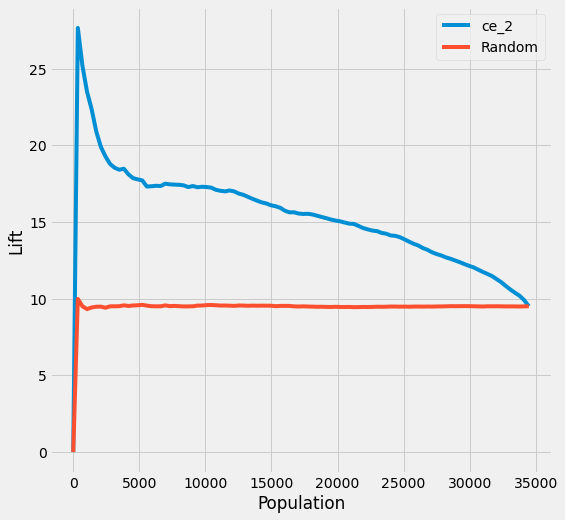

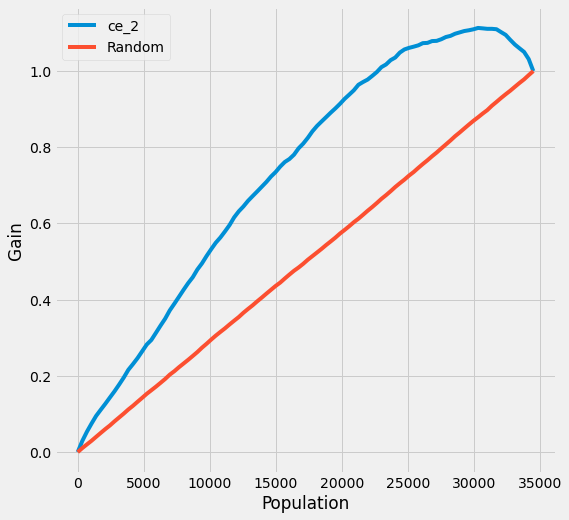

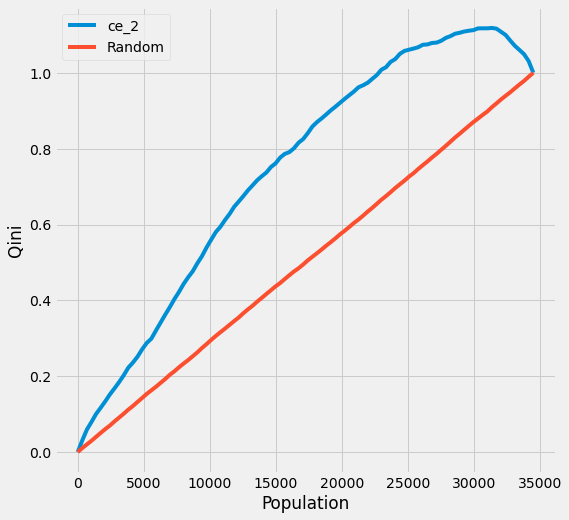

In [79]:
plot_lift_curve(pred_df, y_col, treatment_col)
plot_uplift_curve(pred_df, y_col, treatment_col)
plot_qini_curve(pred_df, y_col, treatment_col)

In [802]:
#  xgb
#2
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:         Learner      auuc      Lift
3  ce_2_ensemble  0.735256  0.471362
1           ce_2  0.735067  0.470984
5       ce_2_xgb  0.730942  0.462729
6         Random  0.499711  0.000000
4       ce_1_xgb  0.428204 -0.143097
0           ce_1  0.412670 -0.174184
2  ce_1_ensemble  0.372845 -0.253878
INFO:NBOE:         Learner      qini
1           ce_2  0.247805
3  ce_2_ensemble  0.245182
5       ce_2_xgb  0.231649
6         Random  0.000000
0           ce_1 -0.086450
4       ce_1_xgb -0.092587
2  ce_1_ensemble -0.132792


,Learner,qini
1,ce_2,0.247805
3,ce_2_ensemble,0.245182
5,ce_2_xgb,0.231649
6,Random,0.000000
0,ce_1,-0.086450
4,ce_1_xgb,-0.092587
2,ce_1_ensemble,-0.132792


In [804]:
# xgb
0.730942-0.036228 

0.6947139999999999

In [805]:
# ensemble
0.735256-0.267858

0.46739800000000004

In [808]:
#  xgb
# t 1
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:         Learner      auuc      Lift
3  ce_2_ensemble  0.735256  0.471362
1           ce_2  0.735067  0.470984
5       ce_2_xgb  0.730942  0.462729
6         Random  0.499711  0.000000
4       ce_1_xgb  0.428204 -0.143097
0           ce_1  0.412670 -0.174184
2  ce_1_ensemble  0.372845 -0.253878
INFO:NBOE:         Learner      qini
1           ce_2  0.247805
3  ce_2_ensemble  0.245182
5       ce_2_xgb  0.231649
6         Random  0.000000
0           ce_1 -0.086450
4       ce_1_xgb -0.092587
2  ce_1_ensemble -0.132792


,Learner,qini
1,ce_2,0.247805
3,ce_2_ensemble,0.245182
5,ce_2_xgb,0.231649
6,Random,0.000000
0,ce_1,-0.086450
4,ce_1_xgb,-0.092587
2,ce_1_ensemble,-0.132792


In [671]:
final_train_cols =['V_2', 'V_3','V_15', 'V_28',  'V_34','V_33','V_31']
xgb t 2

INFO:NBOE:  Learner      auuc      Lift
1    ce_2  1.326374  1.654282
0    ce_1  0.872020  0.745048
2  Random  0.499711  0.000000
INFO:NBOE:  Learner      qini
1    ce_2  0.841496
0    ce_1  0.443872
2  Random  0.000000


t1 
INFO:NBOE:  Learner      auuc       Lift
0    ce_1  5.026484 -10.905273
1    ce_2  1.651598  -4.254667
2  Random -0.507455   0.000000
INFO:NBOE:  Learner      qini
0    ce_1  5.634866
1    ce_2  2.056207
2  Random  0.000000



SyntaxError: invalid syntax (2049599257.py, line 2)

In [ ]:
feature ['V_2','V_15', 'V_28',  'V_34','V_33','V_31']
xgb t 2    best_xgb_3.csv
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.733041  0.466929
0    ce_1  0.517138  0.034873
2  Random  0.499711  0.000000
INFO:NBOE:  Learner      qini
1    ce_2  0.255316
2  Random  0.000000
0    ce_1 -0.000868

xgb t 1
INFO:NBOE:  Learner      auuc      Lift
0    ce_1  0.569103 -2.121483
1    ce_2 -0.358234 -0.294058
2  Random -0.507455  0.000000
INFO:NBOE:  Learner      qini
0    ce_1  1.010097
1    ce_2  0.133302
2  Random  0.000000



ensemble t2    best_ensemble_3.csv
INFO:NBOE:  Learner      auuc      Lift
0    ce_1  0.751654 -2.481223
1    ce_2 -0.222024 -0.562476
2  Random -0.507455  0.000000
INFO:NBOE:  Learner      qini
0    ce_1  1.175554
1    ce_2  0.282659
2  Random  0.000000

ensemble t1
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.766593  0.534072
2  Random  0.499711  0.000000
0    ce_1  0.458437 -0.082595
INFO:NBOE:  Learner      qini
1    ce_2  0.264940
2  Random  0.000000
0    ce_1 -0.061181

In [ ]:
feature  ['V_2', 'V_3','V_15', 'V_17', 'V_28',  'V_34','V_33','V_31']

ensemble    best_ensemble_2.csv
treatment 1
INFO:NBOE:  Learner      auuc      Lift
0    ce_1 -0.096387 -0.810058
1    ce_2 -0.310537 -0.388050
2  Random -0.507455  0.000000
INFO:NBOE:  Learner      qini
0    ce_1  0.424901
1    ce_2  0.190477
2  Random  0.000000

treatment 2
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.740262  0.481380
2  Random  0.499711  0.000000
0    ce_1  0.430416 -0.138671
INFO:NBOE:  Learner      qini
1    ce_2  0.251523
2  Random  0.000000
0    ce_1 -0.063458




xgb  best_xgb_2.csv

treatment 1
INFO:NBOE:  Learner      auuc      Lift
0    ce_1  0.056963 -1.112253
1    ce_2 -0.307025 -0.394972
2  Random -0.507455  0.000000
INFO:NBOE:  Learner      qini
0    ce_1  0.525844
1    ce_2  0.192757
2  Random  0.000000

treatment 2
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.743615  0.488090
2  Random  0.499711  0.000000
0    ce_1  0.448259 -0.102965
INFO:NBOE:  Learner      qini
1    ce_2  0.256179
2  Random  0.000000
0    ce_1 -0.054512

In [ ]:
feature ['V_2', 'V_3', 'V_4', 'V_6', 'V_11', 'V_15', 'V_17', 'V_19', 'V_28', 'V_30', 'V_34', 'V_39']
ensemble    best_ensemble.csv
treatment 1  
INFO:NBOE:  Learner      auuc      Lift
0    ce_1  0.824334 -2.624447
1    ce_2 -0.285578 -0.437235
2  Random -0.507455  0.000000
INFO:NBOE:  Learner      qini
0    ce_1  1.429087
1    ce_2  0.218177
2  Random  0.000000


treatment 2
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.822794  0.646539
2  Random  0.499711  0.000000
0    ce_1  0.457749 -0.083973
INFO:NBOE:  Learner      qini
1    ce_2  0.337866
2  Random  0.000000
0    ce_1 -0.044398



xgb    best_xgb.csv
treatment 2
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.902278  0.805600
0    ce_1  0.500566  0.001711
2  Random  0.499711  0.000000
INFO:NBOE:  Learner      qini
1    ce_2  0.414913
0    ce_1  0.005445
2  Random  0.000000

treatment 1
INFO:NBOE:  Learner      auuc      Lift
0    ce_1  1.042266 -3.053906
1    ce_2 -0.325928 -0.357720
2  Random -0.507455  0.000000
INFO:NBOE:  Learner      qini
0    ce_1  1.592285
1    ce_2  0.181378
2  Random  0.000000



ctb  best_ctb.csv


treatment 1
INFO:NBOE:  Learner      auuc      Lift
0    ce_1 -0.336276 -0.337329
1    ce_2 -0.336761 -0.336374
2  Random -0.507455  0.000000
INFO:NBOE:  Learner      qini
1    ce_2  0.161089
0    ce_1  0.144424
2  Random  0.000000

treatment 2
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.716506  0.433840
2  Random  0.499711  0.000000
0    ce_1  0.402648 -0.194239
INFO:NBOE:  Learner      qini
1    ce_2  0.225986
2  Random  0.000000
0    ce_1 -0.097080

In [745]:
# outcome  no norm
# xgb 2 
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.818503  0.637952
2  Random  0.499711  0.000000
0    ce_1  0.384378 -0.230800
INFO:NBOE:  Learner      qini
1    ce_2  0.385154
2  Random  0.000000
0    ce_1 -0.095784

# xgb 1
INFO:NBOE:  Learner      auuc      Lift
0    ce_1 -0.403864 -0.204139
2  Random -0.507455  0.000000
1    ce_2 -0.742472  0.463128
INFO:NBOE:  Learner      qini
2  Random  0.000000
0    ce_1 -0.006563
1    ce_2 -0.317511


#lgb 2
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.788467  0.577846
0    ce_1  0.550514  0.101665
2  Random  0.499711  0.000000
INFO:NBOE:  Learner      qini
1    ce_2  0.307893
0    ce_1  0.121282
2  Random  0.000000


#lgb 1
INFO:NBOE:  Learner      auuc      Lift
0    ce_1 -0.449598 -0.114014
2  Random -0.507455  0.000000
1    ce_2 -0.570791  0.124810
INFO:NBOE:  Learner      qini
0    ce_1  0.023558
2  Random  0.000000
1    ce_2 -0.067964



# ctb 2
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.787497  0.575905
2  Random  0.499711  0.000000
0    ce_1  0.406831 -0.185867
INFO:NBOE:  Learner      qini
1    ce_2  0.266044
2  Random  0.000000
0    ce_1 -0.131707


# ctb 1
INFO:NBOE:  Learner      auuc      Lift
0    ce_1 -0.016128 -0.968217
1    ce_2 -0.263487 -0.480768
2  Random -0.507455  0.000000
INFO:NBOE:  Learner      qini
0    ce_1  0.477479
1    ce_2  0.245321
2  Random  0.000000



# ensemble all  2
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.866669  0.734341
2  Random  0.499711  0.000000
0    ce_1  0.440803 -0.117884
INFO:NBOE:  Learner      qini
1    ce_2  0.412100
2  Random  0.000000
0    ce_1 -0.088577



# ensemble all  1
INFO:NBOE:  Learner      auuc      Lift
0    ce_1  0.133519 -1.263114
2  Random -0.507455  0.000000
1    ce_2 -0.553216  0.090177
INFO:NBOE:  Learner      qini
0    ce_1  0.624971
2  Random  0.000000
1    ce_2 -0.089944



result_finetune_noNorm_lgb_ctb_xgb_ensemble_newfeature
#y learn feature 2
INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.754255  0.509382
0    ce_1  0.577257  0.155182
2  Random  0.499711  0.000000
INFO:NBOE:  Learner      qini
1    ce_2  0.272594
0    ce_1  0.101435
2  Random  0.000000

#y learn feature 1
INFO:NBOE:  Learner      auuc      Lift
2  Random -0.507455  0.000000
1    ce_2 -0.619489  0.220775
0    ce_1 -0.756363  0.490502
INFO:NBOE:  Learner      qini
2  Random  0.000000
1    ce_2 -0.118880
0    ce_1 -0.254553



SyntaxError: invalid syntax (593571900.py, line 3)

In [63]:
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.822794  0.646539
2  Random  0.499711  0.000000
0    ce_1  0.457749 -0.083973
INFO:NBOE:  Learner      qini
1    ce_2  0.337866
2  Random  0.000000
0    ce_1 -0.044398


,Learner,qini
1,ce_2,0.337866
2,Random,0.000000
0,ce_1,-0.044398


In [ ]:
# all
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.748435  0.497735
2  Random  0.499711  0.000000
0    ce_1  0.393585 -0.212375
INFO:NBOE:  Learner      qini
1    ce_2  0.303551
2  Random  0.000000
0    ce_1 -0.128927


,Learner,qini
1,ce_2,0.303551
2,Random,0.000000
0,ce_1,-0.128927


In [ ]:
# lgb
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.677442  0.355668
0    ce_1  0.598800  0.198292
2  Random  0.499711  0.000000
INFO:NBOE:  Learner      qini
1    ce_2  0.233054
0    ce_1  0.116639
2  Random  0.000000


,Learner,qini
1,ce_2,0.233054
0,ce_1,0.116639
2,Random,0.000000


In [ ]:
# ctb
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:  Learner      auuc      Lift
0    ce_1  0.201262 -1.396610
2  Random -0.507455  0.000000
1    ce_2 -0.693083  0.365802
INFO:NBOE:  Learner      qini
0    ce_1  0.636702
2  Random  0.000000
1    ce_2 -0.226575


,Learner,qini
0,ce_1,0.636702
2,Random,0.000000
1,ce_2,-0.226575


In [ ]:
pred_df.shape

(34474, 4)

In [ ]:
# ctb
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:  Learner      auuc      Lift
2  Random -0.507455  0.000000
1    ce_2 -0.693083  0.365802
0    ce_1 -0.963067  0.897835
INFO:NBOE:  Learner      qini
2  Random  0.000000
1    ce_2 -0.226551
0    ce_1 -0.581937


,Learner,qini
2,Random,0.000000
1,ce_2,-0.226551
0,ce_1,-0.581937


In [180]:
# 
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.587912  0.176504
2  Random  0.499711  0.000000
0    ce_1  0.473387 -0.052678
INFO:NBOE:  Learner      qini
1    ce_2  0.115798
2  Random  0.000000
0    ce_1 -0.010582


,Learner,qini
1,ce_2,0.115798
2,Random,0.000000
0,ce_1,-0.010582


In [273]:
# 
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.732395  0.465636
0    ce_1  0.621989  0.244697
2  Random  0.499711  0.000000
INFO:NBOE:  Learner      qini
1    ce_2  0.172682
0    ce_1  0.103123
2  Random  0.000000


,Learner,qini
1,ce_2,0.172682
0,ce_1,0.103123
2,Random,0.000000


In [393]:
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:  Learner      auuc      Lift
0    ce_1 -0.141430 -0.721295
2  Random -0.507455  0.000000
1    ce_2 -0.732899  0.444264
INFO:NBOE:  Learner      qini
0    ce_1  0.370171
2  Random  0.000000
1    ce_2 -0.295856


,Learner,qini
0,ce_1,0.370171
2,Random,0.000000
1,ce_2,-0.295856


In [401]:
get_auuc(pred_df, y_col, treatment_col)
get_qini(pred_df, y_col, treatment_col)

INFO:NBOE:  Learner      auuc      Lift
1    ce_2  0.767943  0.536773
2  Random  0.499711  0.000000
0    ce_1  0.482682 -0.034077
INFO:NBOE:  Learner      qini
1    ce_2  0.319525
2  Random  0.000000
0    ce_1 -0.006677


,Learner,qini
1,ce_2,0.319525
2,Random,0.000000
0,ce_1,-0.006677


##  EconML 

In [304]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
from xgboost import XGBRegressor, XGBClassifier

# EconML imports
from econml.dr import LinearDRLearner

import matplotlib.pyplot as plt
import seaborn as sns

import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

In [292]:
# Import the sample pricing data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_url)

In [294]:
# Data sample
train_data.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.0,3.917117
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.0,11.585706
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.0,24.675960
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.0,6.361776
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.8,12.624123


In [295]:
train_data["price"].value_counts()

1.0    4346
0.8    3089
0.9    2565
Name: price, dtype: int64

In [296]:
# Define estimator inputs
Y = train_data["demand"]  # outcome of interest
T = train_data["price"]  # intervention, or treatment
X = train_data[["income"]]  # features
W = train_data.drop(columns=["demand", "price", "income"])  # confounders

In [297]:
# Get test data
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
X_test_data = pd.DataFrame(X_test, columns=["income"])

In [300]:
# Define underlying treatment effect function given DGP
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)

def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)

def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y

def true_te(x, n, stats):
    if x < 1:
        subdata = train_data[train_data["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = train_data[train_data["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)

In [301]:
# Get the estimate and range of true treatment effect
truth_te_estimate = np.apply_along_axis(true_te, 1, X_test, 1000, "mean")  # estimate
truth_te_upper = np.apply_along_axis(true_te, 1, X_test, 1000, 95)  # upper level
truth_te_lower = np.apply_along_axis(true_te, 1, X_test, 1000, 5)  # lower level

In [302]:
# Get log_T and log_Y
log_T = np.log(T)
log_Y = np.log(Y)

In [305]:
# Train EconML model
est = LinearDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    featurizer=PolynomialFeatures(degree=2, include_bias=False),
)
est.fit(log_Y, log_T, X=X, W=W, inference="statsmodels")
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)

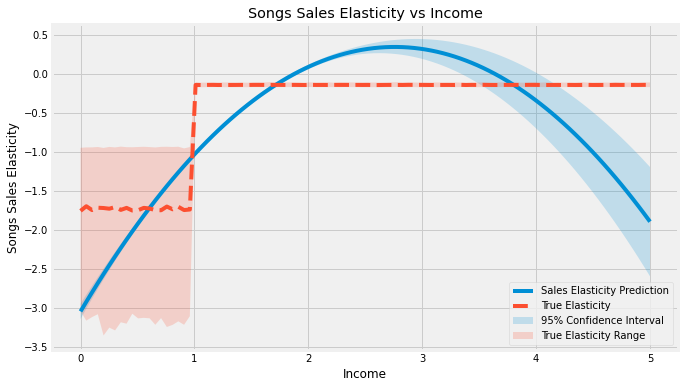

In [306]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0],
    te_pred_interval[1],
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

In [307]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
income,2.461,0.082,29.848,0.0,2.299,2.623
income^2,-0.446,0.029,-15.631,0.0,-0.502,-0.39
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-3.042,0.05,-60.702,0.0,-3.14,-2.944


In [308]:
# Train EconML model
est = CausalForestDML(
    model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor()
)
est.fit(log_Y, log_T, X=X, W=W, inference="blb")
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)

In [312]:
te_pred

array([-1.64944302, -1.64944302, -1.64944302, -1.64944302, -1.64944302,
       -1.63210226, -1.86228328, -1.80370634, -1.81153832, -1.83626374,
       -1.70296428, -1.82251639, -1.72257623, -1.76619564, -1.54463947,
       -1.69466223, -1.82629689, -1.61449738, -1.9800067 , -1.76277802,
       -0.13035725, -0.12860501, -0.13770106, -0.13053568, -0.138361  ,
       -0.11694952, -0.14833598, -0.11214292, -0.13128215, -0.12794992,
       -0.1720432 , -0.12356555, -0.12690273, -0.11583471, -0.12333474,
       -0.12707119, -0.10770493, -0.12881381, -0.11621425, -0.13547131,
       -0.1071469 , -0.12740418, -0.10285573, -0.12187725, -0.14559709,
       -0.14685258, -0.13424648, -0.13308619, -0.14144747, -0.1261548 ,
       -0.13561546, -0.13672362, -0.12912726, -0.13010326, -0.1282378 ,
       -0.12385598, -0.12209028, -0.1184788 , -0.11403368, -0.12571645,
       -0.13425712, -0.13722397, -0.13255956, -0.12771935, -0.12459848,
       -0.12782557, -0.12935319, -0.12949986, -0.12958049, -0.12

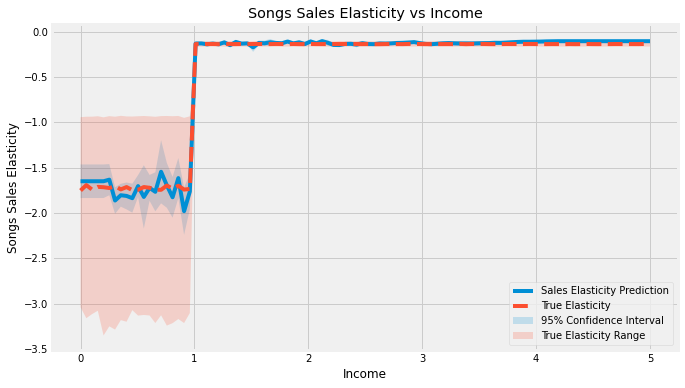

In [313]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0],
    te_pred_interval[1],
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

In [314]:
# Main imports
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner

# Helper imports 
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

%matplotlib inline

In [316]:
# Define DGP
def generate_data(n, d, controls_outcome, treatment_effect, propensity):
    """Generates population data for given untreated_outcome, treatment_effect and propensity functions.
    
    Parameters
    ----------
        n (int): population size
        d (int): number of covariates
        controls_outcome (func): untreated outcome conditional on covariates
        treatment_effect (func): treatment effect conditional on covariates
        propensity (func): probability of treatment conditional on covariates
    """
    # Generate covariates
    X = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # Generate treatment
    T = np.apply_along_axis(lambda x: binomial(1, propensity(x), 1)[0], 1, X)
    # Calculate outcome
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treat_effect * T
    return (Y, T, X)

In [317]:
# controls outcome, treatment effect, propensity definitions
def generate_controls_outcome(d):
    beta = uniform(-3, 3, d)
    return lambda x: np.dot(x, beta) + normal(0, 1)
treatment_effect = lambda x: (1 if x[1] > 0.1 else 0)*8
propensity = lambda x: (0.8 if (x[2]>-0.5 and x[2]<0.5) else 0.2)

In [318]:
# DGP constants and test data
d = 5
n = 1000
n_test = x
controls_outcome = generate_controls_outcome(d)
X_test = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
delta = 6/n_test
X_test[:, 1] = np.arange(-3, 3, delta)

In [319]:
Y, T, X = generate_data(n, d, controls_outcome, treatment_effect, propensity)

In [322]:
X

array([[-1.23063295,  1.22307916,  1.65313605, -0.40121138, -1.14040187],
       [ 0.11335088, -1.49791412, -0.42395659,  0.04537279, -1.89396944],
       [ 0.08634543,  0.49018902,  0.85666619, -0.4543643 , -0.28039825],
       ...,
       [ 0.48531364,  0.04659087,  1.52139249,  1.47016195, -1.28043204],
       [ 0.77144584, -0.60709936, -1.06621347, -0.17309518,  0.74062916],
       [-0.21504028, -1.61860547, -0.196944  , -0.920796  , -0.38890635]])